# Developing and tuning a LightGBM Classifier

In this notebook, the yoghurt data with dummy variables is used to build and tune a LightGBM Classifier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load data and remove irrelevant variables

In [2]:
data = pd.read_csv("../02_data_preparation/yoghurt_w_dummy_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21251 entries, 0 to 21250
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 21251 non-null  int64  
 1   first_purchase             21251 non-null  bool   
 2   shelf_price                21251 non-null  float64
 3   pct_disc                   21251 non-null  float64
 4   pct_retail_disc            21251 non-null  float64
 5   pct_coupon_disc            21251 non-null  float64
 6   display_1                  21251 non-null  int64  
 7   display_2                  21251 non-null  int64  
 8   display_3                  21251 non-null  int64  
 9   display_4                  21251 non-null  int64  
 10  display_5                  21251 non-null  int64  
 11  display_6                  21251 non-null  int64  
 12  display_7                  21251 non-null  int64  
 13  display_9                  21251 non-null  int

In [3]:
data.drop(labels=["Unnamed: 0", "display_1", "display_5", "display_A", "campaign_6.0", "campaign_30.0", "description_TypeC"],
          axis = 1, inplace = True)

In [4]:
pd.set_option("display.max_columns", None)
data.describe(include = "all")

,first_purchase,shelf_price,pct_disc,pct_retail_disc,pct_coupon_disc,display_2,display_3,display_4,display_6,display_7,display_9,mailer_A,mailer_C,mailer_D,mailer_H,mailer_J,marital_status_A,marital_status_B,homeowner_Homeowner,homeowner_Probable Owner,homeowner_Probable Renter,homeowner_Renter,hhcomp_1 Adult Kids,hhcomp_2 Adults Kids,hhcomp_2 Adults No Kids,hhcomp_Single Female,hhcomp_Single Male,kid_category_1,kid_category_2,kid_category_3+,kid_category_None/Unknown,age_19-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,income_100-124K,income_125-149K,income_15-24K,income_150-174K,income_175-199K,income_200-249K,income_25-34K,income_250K+,income_35-49K,income_50-74K,income_75-99K,income_Under 15K,hhsize_1,hhsize_2,hhsize_3,hhsize_4,hhsize_5+,campaign_8.0,campaign_13.0,campaign_18.0,campaign_29.0,description_TypeA,description_TypeB
count,21251,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.00000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,14083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.156933,0.158316,0.153330,0.004987,0.011152,0.007623,0.001082,0.005459,0.012046,0.004047,0.148699,0.001223,0.048751,0.008235,0.005270,0.488918,0.125406,0.686321,0.015152,0.005176,0.037834,0.061974,0.295092,0.314009,0.147711,0.122677,0.159240,0.098537,0.102254,0.63997,0.042727,0.211896,0.276975,0.347701,0.067009,0.053692,0.080420,0.074820,0.054586,0.085972,0.017646,0.006870,0.079384,0.017646,0.180086,0.224037,0.126394,0.052139,0.280975,0.374476,0.156746,0.089596,0.098207,0.076373,0.077879,0.075855,0.006776,0.230248,0.006776
std,NaN,1.104681,0.145841,0.137543,0.044610,0.105017,0.086979,0.032881,0.073682,0.109096,0.063488,0.355800,0.034958,0.215351,0.090374,0.072407,0.499889,0.331186,0.463999,0.122161,0.071761,0.190798,0.241113,0.456095,0.464131,0.354821,0.328073,0.365908,0.298046,0.302989,0.48002,0.202247,0.408661,0.447515,0.476252,0.250043,0.225413,0.271948,0.263107,0.227175,0.280330,0.131665,0.082604,0.270344,0.131665,0.384268,0.416956,0.332301,0.222312,0.449486,0.483999,0.363569,0.285609,0.297602,0.265600,0.267987,0.264773,0.082040,0.421001,0.082040
min,NaN,0.350000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.400000,0.

## Build initial LightGBM model

Importing modules, splitting data in test and train data and fitting an initial LightGBM Classifier 

In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import lightgbm as lgb

In [6]:
X = data.drop("first_purchase", axis = 1)
y = data["first_purchase"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify = y)

The data has a certain structure based on households, products, and time during the observation period. In order to avoid the risk of systematic effects, StratifiedShuffleSplit is selected for cross-validation instead of StratifiedKFold.

In [8]:
cv = StratifiedShuffleSplit(n_splits = 5) 

In [9]:
from metrics import cross_val_scores, test_scores, train_scores

In [12]:
lgbm =  lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [13]:
cross_val_scores(lgbm, X_train, y_train, cv)

0.49258640421539146
0.6798897869464973
0.3863874345549738
0.7303529411764706


In [14]:
test_scores(lgbm, X_test, y_test)

0.5083700440528636
0.6901913875598086
0.40237099023709905
0.7374735356386732


While better than the benchmark model, the performance of the initial model is far from good.

In [15]:
train_scores(lgbm, X_train, y_train)

0.5745747928477977
0.766433973240256
0.4595395884199512
0.7704705882352941


In [16]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## Hyperparameter tuning

We begin hyperparameter tuning with random search for a few key hyperparameters and manage to increase f1 considerably.

In [8]:
import scipy

In [19]:
rand_params = {'max_depth': scipy.stats.randint(5,30), "subsample": np.arange(0.6,1,0.1), "colsample_bytree": np.arange(0.6,1,0.1),
                  "n_estimators": scipy.stats.randint(50, 250), "learning_rate": np.arange(0.05,0.3,0.05), "num_leaves": scipy.stats.randint(5,50),
                  "boosting_type" : ["gbdt", "dart"]}

In [20]:
rand_search = RandomizedSearchCV(lgbm, rand_params, n_iter=30, scoring = "f1", cv = cv)

In [24]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
                   estimator=LGBMClassifier(), n_iter=30,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'colsample_bytree': array([0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25]),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C020F1B310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C020F1C520>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C01B9CE4C0>,
                                        'subsample': array([0.6, 0.7, 0.8, 0.9])},
                   scoring='f1')

In [25]:
rand_search.best_score_

0.6074860359804284

In [26]:
rand_search.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'learning_rate': 0.2,
 'max_depth': 11,
 'n_estimators': 207,
 'num_leaves': 44,
 'subsample': 0.6}

## Validation

The parameters from random search already represent a big leap ahead.
Learning curve and validation curves show that the model is learning, but it is also overfitting.
Indications for improving the model are derived from cross validation curves.

In [8]:
from plotting import plot_learning_curve, plot_validation_curve

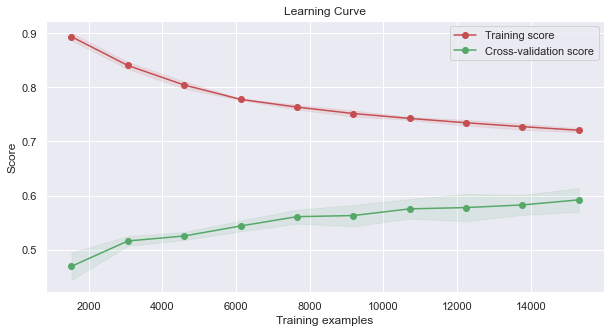

In [28]:
learning_curve = plot_learning_curve(rand_search.best_estimator_, X_train, y_train, cv = cv,  
                          train_sizes = np.linspace(.1, 1, 10), scoring = "f1")           

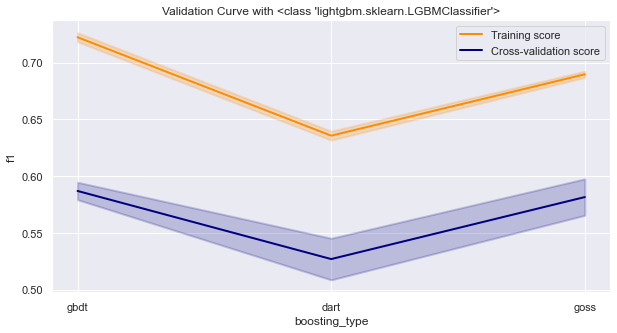

In [61]:
val_boosting_type = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv = cv, 
                                      param_name ="boosting_type", param_range = ["gbdt", "dart", "goss"], scoring = "f1")

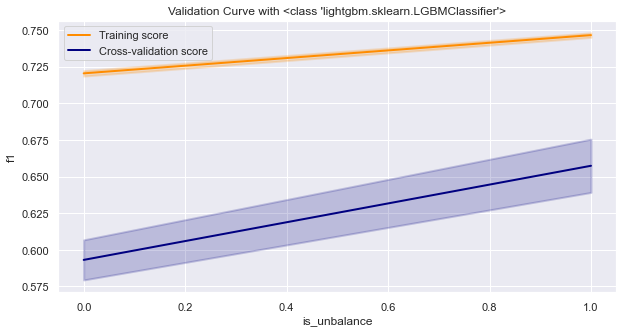

In [32]:
val_is_unbalance = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "is_unbalance", param_range = [True, False], scoring="f1")

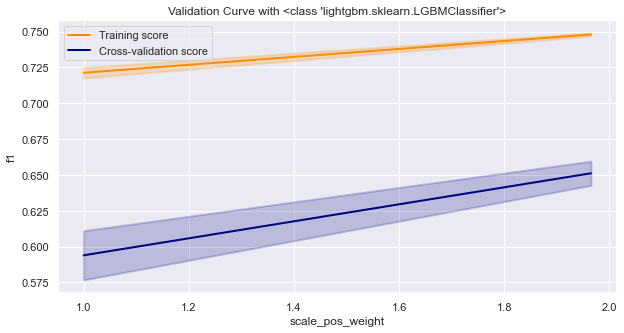

In [34]:
val_scale_pos_weight = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "scale_pos_weight", param_range = [1, 1.965], scoring="f1")

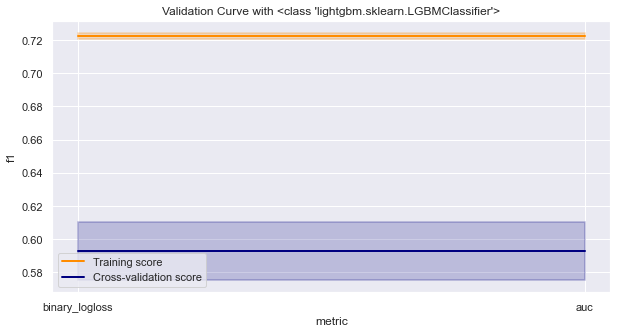

In [35]:
val_metric = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "metric", param_range = ["binary_logloss", "auc"], scoring="f1")

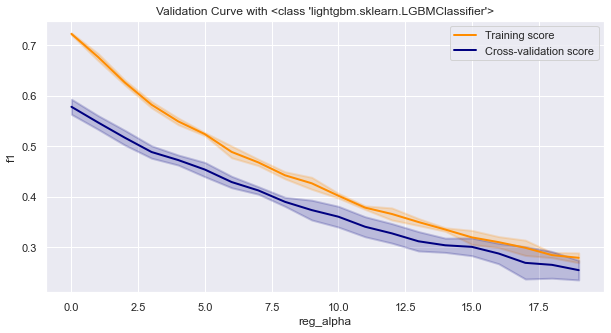

In [40]:
val_lambda_l1 = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "reg_alpha", param_range = np.arange(0,20,1), scoring="f1")

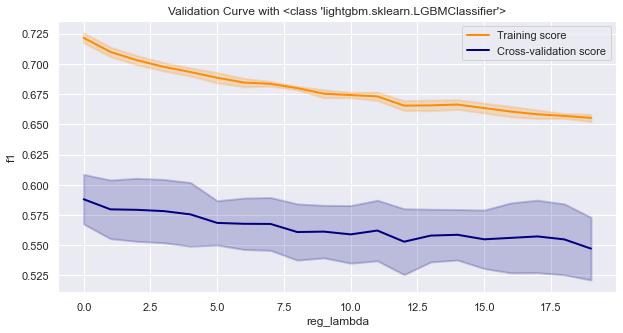

In [56]:
val_lambda_l2 = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "reg_lambda", param_range = np.arange(0,20,1), scoring="f1")

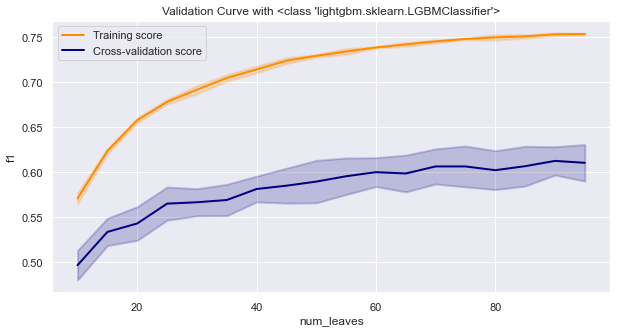

In [41]:
val_num_leaves = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "num_leaves", param_range = np.arange(10,100,5), scoring="f1")

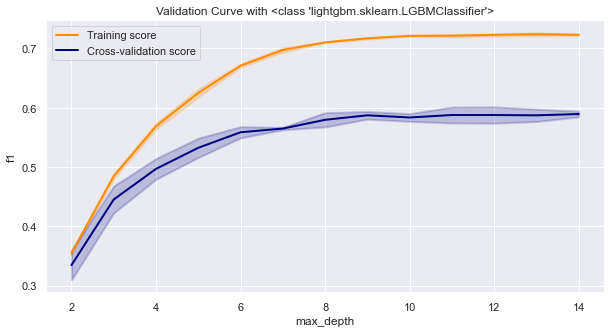

In [80]:
val_max_depth = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "max_depth", param_range = np.arange(2,15,1), scoring="f1")

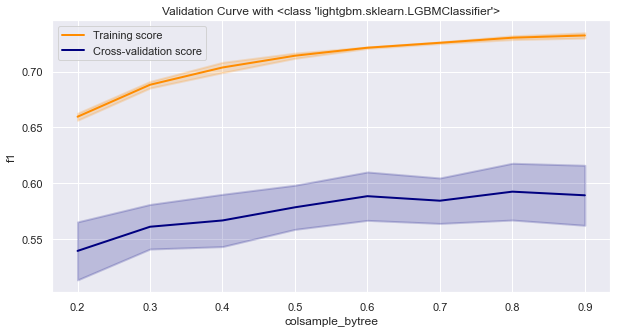

In [48]:
val_colsample_bytree = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "colsample_bytree", param_range = np.arange(0.2, 1, 0.1), scoring="f1")

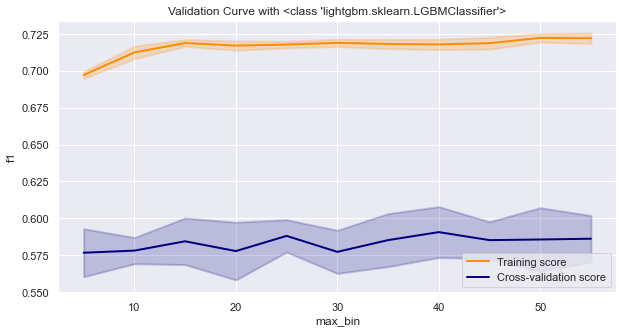

In [89]:
val_max_bin = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "max_bin", param_range = np.arange(5, 60, 5), scoring="f1")

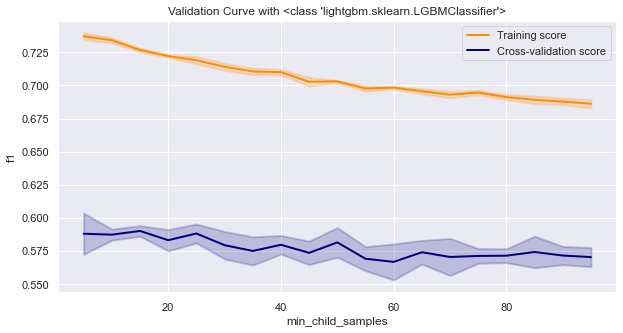

In [53]:
val_min_child_samples = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "min_child_samples", param_range = np.arange(5, 100, 5), scoring="f1")

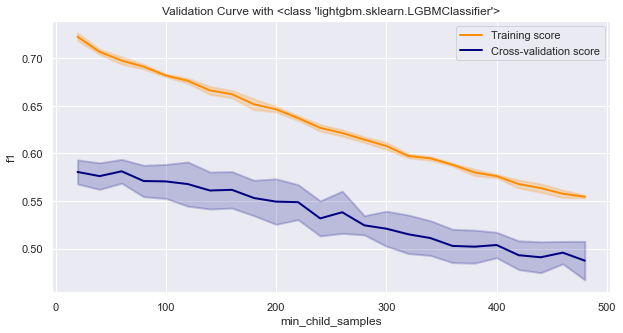

In [54]:
val_min_child_samples = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "min_child_samples", param_range = np.arange(20, 500, 20), scoring="f1")

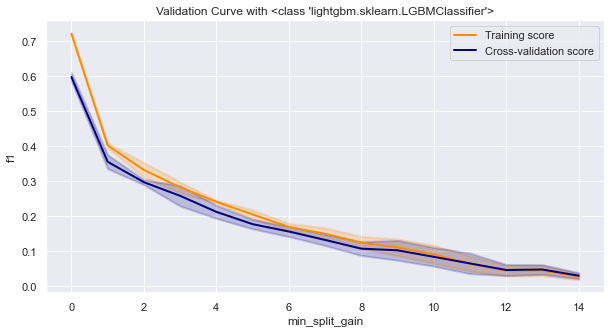

In [58]:
val_min_split_gain = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "min_split_gain", param_range = np.arange(0, 15, 1), scoring="f1")

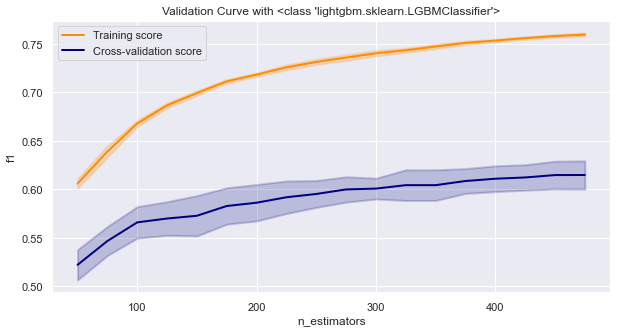

In [59]:
val_n_estimators = plot_validation_curve(rand_search.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "n_estimators", param_range = np.arange(50, 500, 25), scoring="f1")

## Further hyperparameter tuning

Based on indications from crossvalidation curves, we define a new baseline model lgbm_2 and a parameter grid for grid search.

In [90]:
lgbm_2 =  lgb.LGBMClassifier(objective = "binary", is_unbalance = True, max_depth = 9)

In [9]:
grid_params = {"boosting_type": ["gbdt", "goss"], "learning_rate": [0.3, 0.4, 0.5], "reg_alpha": [0, 1], 
               "num_leaves": [70, 90], "colsample_bytree": [0.6, 0.8], "max_bin": [25, 40], 
               "min_child_samples": [25, 50], "n_estimators": [400, 500]}

In [95]:
grid_search = GridSearchCV(lgbm_2, param_grid = grid_params, scoring = "f1", cv = cv)

In [96]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=LGBMClassifier(is_unbalance=True, max_depth=9,
                                      objective='binary'),
             param_grid={'boosting_type': ['gbdt', 'goss'],
                         'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.3, 0.4, 0.5], 'max_bin': [25, 40],
                         'min_child_samples': [25, 50],
                         'n_estimators': [400, 500], 'num_leaves': [70, 90],
                         'reg_alpha': [0, 1]},
             scoring='f1')

In [97]:
grid_search.best_score_

0.653784267081125

In [98]:
grid_search.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.5,
 'max_bin': 25,
 'min_child_samples': 50,
 'n_estimators': 400,
 'num_leaves': 70,
 'reg_alpha': 1}

The tuned model lgbm_3 shows even better performance and also the learning curve looks promising.

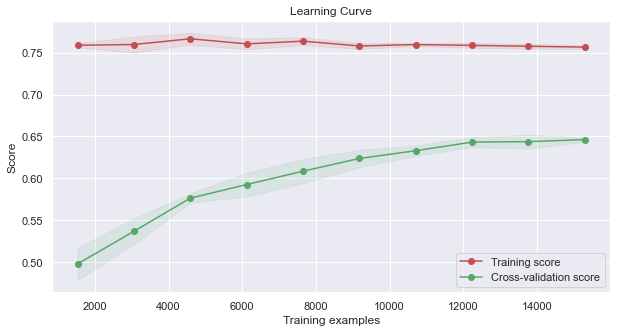

In [99]:
learning_curve = plot_learning_curve(grid_search.best_estimator_, X_train, y_train, cv = cv,  
                          train_sizes = np.linspace(.1, 1, 10), scoring = "f1")           

In [17]:
lgbm_3 =  lgb.LGBMClassifier(objective = "binary", is_unbalance = True, max_depth = 9, boosting_type = 'gbdt', colsample_bytree = 0.8,
                             learning_rate= 0.5,  max_bin= 25,  min_child_samples= 50,  n_estimators= 400, 
                             num_leaves= 70,  reg_alpha= 1)

## More hyperparameter tuning - do we need bagging?

Finally, we try if bagging improves the model performance. We apply random search first, then inspect cross validation curves per hyperparamter, build a parameter grid and conduct grid search.

In [107]:
rand_params_2 = {'subsample': np.arange(0.2,1,0.1), "subsample_freq": np.arange(1,10,1)}

In [108]:
rand_search_2 = RandomizedSearchCV(lgbm_3, rand_params_2, n_iter=30, scoring = "f1", cv = cv)

In [109]:
rand_search_2.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
                   estimator=LGBMClassifier(colsample_bytree=0.8,
                                            is_unbalance=True,
                                            learning_rate=0.5, max_bin=25,
                                            max_depth=9, min_child_samples=50,
                                            n_estimators=400, num_leaves=70,
                                            objective='binary', reg_alpha=1),
                   n_iter=30,
                   param_distributions={'subsample': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'subsample_freq': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   scoring='f1')

In [110]:
rand_search_2.best_score_

0.6441951465410092

In [111]:
rand_search_2.best_params_

{'subsample_freq': 9, 'subsample': 0.9000000000000001}

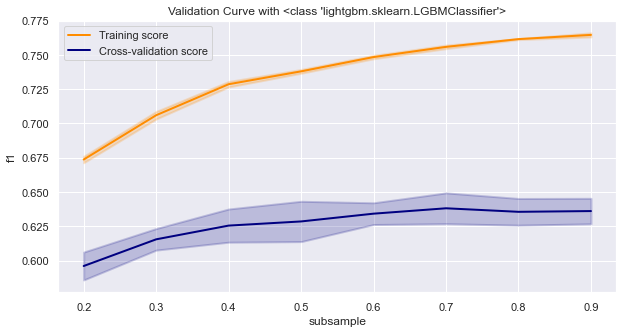

In [112]:
val_subsample = plot_validation_curve(rand_search_2.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "subsample", param_range = np.arange(0.2, 1, 0.1), scoring="f1")

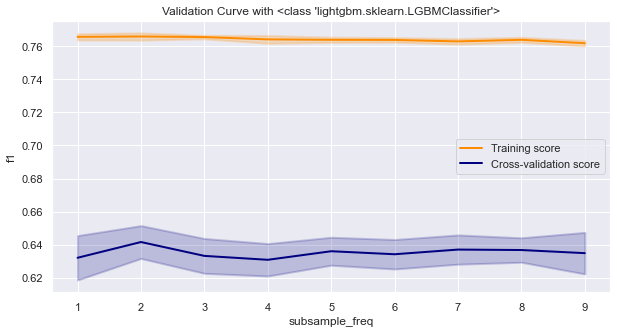

In [113]:
val_subsample_freq = plot_validation_curve(rand_search_2.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "subsample_freq", param_range = np.arange(1, 10, 1), scoring="f1")

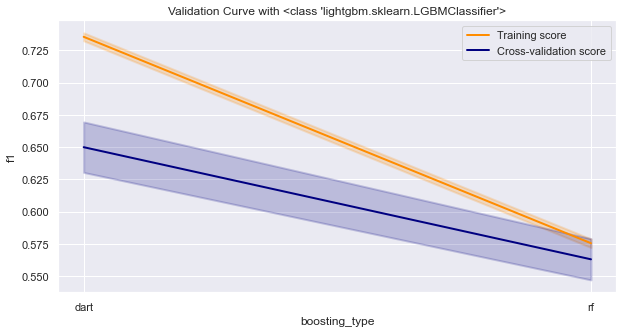

In [114]:
val_boosting_type = plot_validation_curve(rand_search_2.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "boosting_type", param_range = ["gdbt", "dart", "rf", "goss"], scoring="f1")

In [115]:
lgbm_4 =  lgb.LGBMClassifier(objective = "binary", is_unbalance = True, max_depth = 9, colsample_bytree = 0.8,
                             learning_rate= 0.5,  max_bin= 25,  min_child_samples= 50,  n_estimators= 400, 
                             num_leaves= 70,  reg_alpha= 1)

In [124]:
grid_params_2 = {"boosting_type": ["gbdt", "dart", "rf"], "subsample_freq": [2, 5], "subsample": [0.6, 0.7]}

In [125]:
grid_search_2 = GridSearchCV(lgbm_4, param_grid = grid_params_2, scoring = "f1", cv = cv)

In [126]:
grid_search_2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=LGBMClassifier(colsample_bytree=0.8, is_unbalance=True,
                                      learning_rate=0.5, max_bin=25,
                                      max_depth=9, min_child_samples=50,
                                      n_estimators=400, num_leaves=70,
                                      objective='binary', reg_alpha=1),
             param_grid={'boosting_type': ['gbdt', 'dart', 'rf'],
                         'subsample': [0.6, 0.7], 'subsample_freq': [2, 5]},
             scoring='f1')

In [127]:
grid_search_2.best_score_

0.6405515642795383

In [128]:
grid_search_2.best_params_

{'boosting_type': 'gbdt', 'subsample': 0.7, 'subsample_freq': 2}

In [22]:
lgbm_5 =  lgb.LGBMClassifier(objective = "binary", is_unbalance = True, max_depth = 9, colsample_bytree = 0.8,
                             learning_rate= 0.5,  max_bin= 25,  min_child_samples= 50,  n_estimators= 400, 
                             num_leaves= 70,  reg_alpha= 1, boosting_type = "gbdt", subsample = 0.7, subsample_freq = 2)

## Calculate model performance for tuned model without bagging 

In [18]:
lgbm_3.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8, is_unbalance=True, learning_rate=0.5,
               max_bin=25, max_depth=9, min_child_samples=50, n_estimators=400,
               num_leaves=70, objective='binary', reg_alpha=1)

In [19]:
cross_val_scores(lgbm_3, X_train, y_train, cv)

0.6458759702074809
0.6064058961104836
0.7001745200698081
0.7523529411764706


In [20]:
test_scores(lgbm_3, X_test, y_test)

0.6483516483516484
0.6042168674698796
0.699442119944212
0.7440602211244413


In [21]:
train_scores(lgbm_3, X_train, y_train)

0.7579266831722705
0.6991306910269633
0.8275200558074642
0.8217058823529412


## Calculate model performance for tuned model with bagging 

In [23]:
lgbm_5.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8, is_unbalance=True, learning_rate=0.5,
               max_bin=25, max_depth=9, min_child_samples=50, n_estimators=400,
               num_leaves=70, objective='binary', reg_alpha=1, subsample=0.7,
               subsample_freq=2)

In [24]:
cross_val_scores(lgbm_5, X_train, y_train, cv)

0.6519674563743595
0.599908425019377
0.7071553228621291
0.7437647058823529


In [25]:
test_scores(lgbm_5, X_test, y_test)

0.6510569105691058
0.6099939061547837
0.6980474198047419
0.7475888026346742


In [26]:
train_scores(lgbm_5, X_train, y_train)

0.7587701693826764
0.7029599881005504
0.8242064876177189
0.8232352941176471


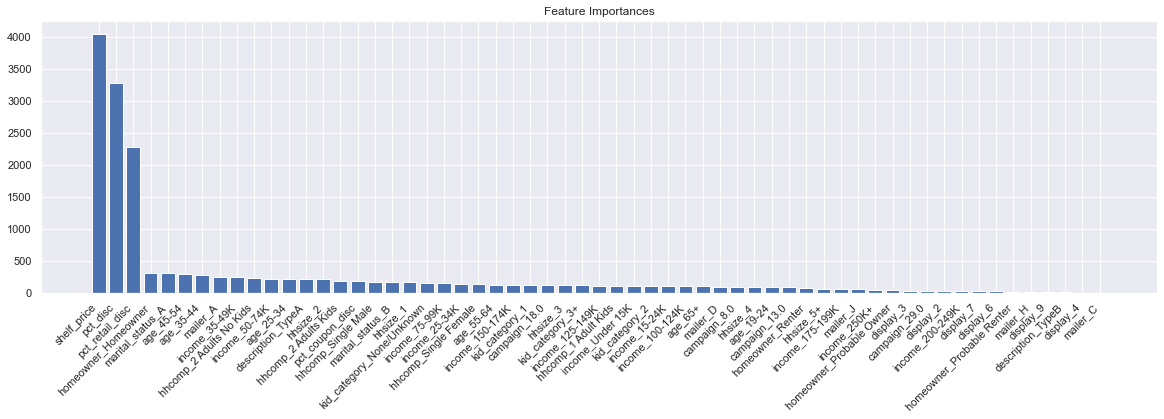

In [27]:
importances_3 = lgbm_3.feature_importances_

indices = np.argsort(importances_3)[::-1]

# rearrange feature names so they match the sorted feature names
# I have my original names list of feature names, which corresponds to the features in the tree.
f_names = [X.columns [i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances_3[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right');

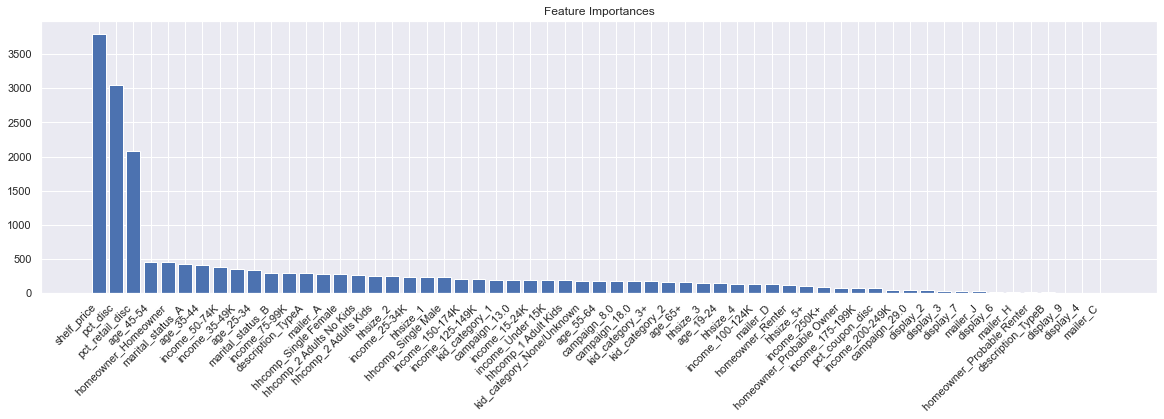

In [28]:
importances_5 = lgbm_5.feature_importances_

indices = np.argsort(importances_5)[::-1]

# rearrange feature names so they match the sorted feature names
# I have my original names list of feature names, which corresponds to the features in the tree.
f_names = [X.columns [i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances_5[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right');

## Monitoring effect of weighting the target variable
The best performing LightGBM Classifiers lgbm_3 and lgbm_5 are based on weighting the target variable in order to mitigate the unbalanced distribution.
The weighting improves f1, but also seems to improve recall at the cost of precision. Ideally, both should be on a similar level to adequately reflect business needs.
Therefore, additional Classifiers are tuned (with and without bagging) without weighting the target variable. F1 turns out to be lower. As expected and contrary to the weighted models, the resulting models perform better on precision than on recall.

We start with model development without taking bagging into account and run grid search with the parameter grid from above

In [10]:
lgbm_2_unbalanced =  lgb.LGBMClassifier(objective = "binary", max_depth = 9)

In [11]:
grid_search_unbalanced = GridSearchCV(lgbm_2_unbalanced, param_grid = grid_params, scoring = "f1", cv = cv)
grid_search_unbalanced.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=LGBMClassifier(max_depth=9, objective='binary'),
             param_grid={'boosting_type': ['gbdt', 'goss'],
                         'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.3, 0.4, 0.5], 'max_bin': [25, 40],
                         'min_child_samples': [25, 50],
                         'n_estimators': [400, 500], 'num_leaves': [70, 90],
                         'reg_alpha': [0, 1]},
             scoring='f1')

In [12]:
grid_search_unbalanced.best_score_

0.6224071439455371

In [13]:
grid_search_unbalanced.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.5,
 'max_bin': 40,
 'min_child_samples': 50,
 'n_estimators': 400,
 'num_leaves': 70,
 'reg_alpha': 0}

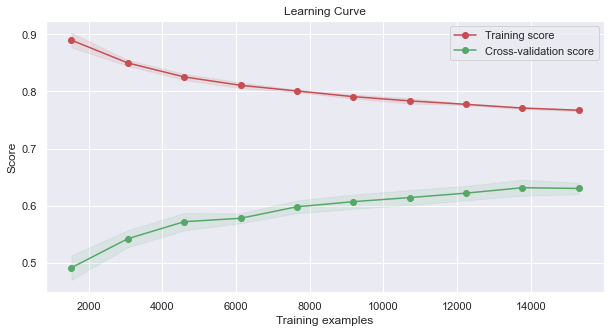

In [14]:
learning_curve = plot_learning_curve(grid_search_unbalanced.best_estimator_, X_train, y_train, cv = cv,  
                          train_sizes = np.linspace(.1, 1, 10), scoring = "f1")       

In [11]:
lgbm_unbalanced =  lgb.LGBMClassifier(objective = "binary", max_depth = 9, 
                                      boosting_type = 'gbdt', colsample_bytree = 0.8, learning_rate= 0.5,  max_bin= 40, 
                                      min_child_samples= 50,  n_estimators= 400, num_leaves= 70,  reg_alpha= 0)

Now we tune for bagging

In [19]:
rand_params_unbalanced = {'subsample': np.arange(0.2,1,0.1), "subsample_freq": np.arange(1,10,1)}

In [20]:
rand_search_unbalanced = RandomizedSearchCV(lgbm_unbalanced, rand_params_unbalanced, n_iter=30, scoring = "f1", cv = cv)

In [21]:
rand_search_unbalanced.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
                   estimator=LGBMClassifier(colsample_bytree=0.8,
                                            learning_rate=0.5, max_bin=40,
                                            max_depth=9, min_child_samples=50,
                                            n_estimators=400, num_leaves=70,
                                            objective='binary', reg_alpha=0),
                   n_iter=30,
                   param_distributions={'subsample': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'subsample_freq': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   scoring='f1')

In [22]:
rand_search_unbalanced.best_score_

0.6191999818411119

In [23]:
rand_search_unbalanced.best_params_

{'subsample_freq': 5, 'subsample': 0.9000000000000001}

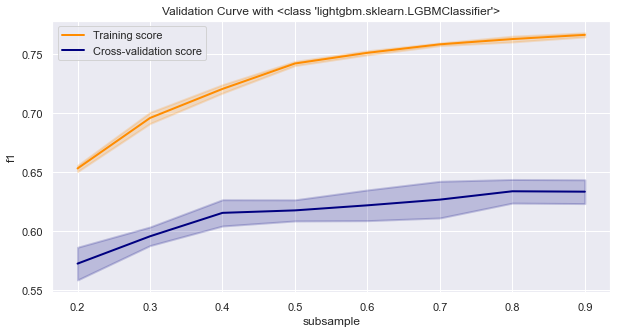

In [24]:
val_subsample = plot_validation_curve(rand_search_unbalanced.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "subsample", param_range = np.arange(0.2, 1, 0.1), scoring="f1")

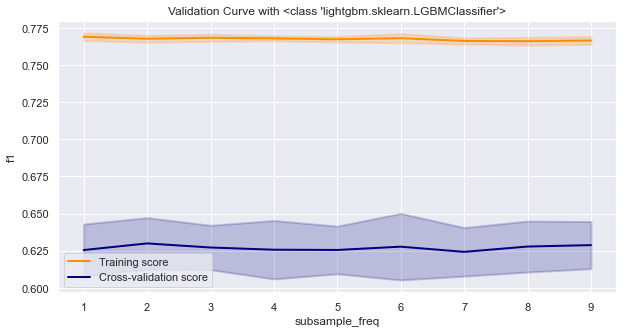

In [25]:
val_subsample_freq = plot_validation_curve(rand_search_unbalanced.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "subsample_freq", param_range = np.arange(1, 10, 1), scoring="f1")

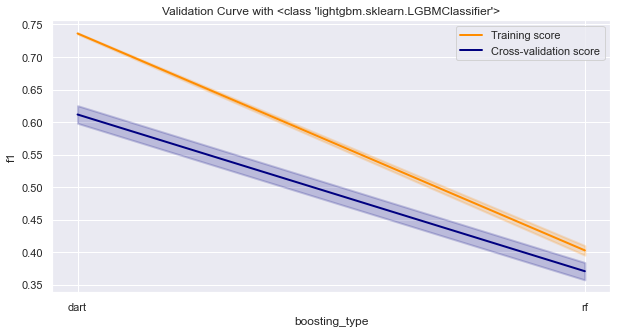

In [26]:
val_boosting_type = plot_validation_curve(rand_search_unbalanced.best_estimator_, X_train, y_train, cv=cv,
                                              param_name = "boosting_type", param_range = ["gdbt", "dart", "rf", "goss"], scoring="f1")

In [27]:
lgbm_unbalanced_2 =  lgb.LGBMClassifier(objective = "binary", max_depth = 9, 
                                      colsample_bytree = 0.8, learning_rate= 0.5,  max_bin= 40, 
                                      min_child_samples= 50,  n_estimators= 400, num_leaves= 70,  reg_alpha= 0)

In [44]:
grid_params_unbalanced_2 = {"subsample": [0.8, 0.9], "subsample_freq": [2, 6, 9], "boosting_type": ["dart", "gdbt"]}

In [45]:
grid_search_unbalanced_2 = GridSearchCV(lgbm_unbalanced_2, param_grid = grid_params_unbalanced_2, scoring = "f1", cv = cv)
grid_search_unbalanced_2.fit(X_train, y_train)

C:\Users\Gabriele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Gabriele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Gabriele\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\Gabriele\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = tr

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=LGBMClassifier(colsample_bytree=0.8, learning_rate=0.5,
                                      max_bin=40, max_depth=9,
                                      min_child_samples=50, n_estimators=400,
                                      num_leaves=70, objective='binary',
                                      reg_alpha=0),
             param_grid={'boosting_type': ['dart', 'gdbt'],
                         'subsample': [0.8, 0.9], 'subsample_freq': [2, 6, 9]},
             scoring='f1')

In [46]:
grid_search_unbalanced_2.best_score_

0.6065359213987639

In [47]:
grid_search_unbalanced_2.best_params_

{'boosting_type': 'dart', 'subsample': 0.9, 'subsample_freq': 9}

In [12]:
lgbm_unbalanced_3 = lgb.LGBMClassifier(objective = "binary", max_depth = 9, 
                                      colsample_bytree = 0.8, learning_rate= 0.5,  max_bin= 40, 
                                      min_child_samples= 50,  n_estimators= 400, num_leaves= 70,  reg_alpha= 0,
                                      boosting_type = "dart", subsample = 0.9, subsample_freq = 9)

## Calculate performance of models without weighting

The model without bagging, lgbm_unbalanced, outperforms the model with bagging, lgbm_unbalanced_3.

In [13]:
lgbm_unbalanced.fit(X_train, y_train)
lgbm_unbalanced_3.fit(X_train, y_train)

LGBMClassifier(boosting_type='dart', colsample_bytree=0.8, learning_rate=0.5,
               max_bin=40, max_depth=9, min_child_samples=50, n_estimators=400,
               num_leaves=70, objective='binary', reg_alpha=0, subsample=0.9,
               subsample_freq=9)

In [14]:
cross_val_scores(lgbm_unbalanced, X_train, y_train, cv)

0.61280015467549
0.6769018302830658
0.556369982547993
0.762


In [15]:
cross_val_scores(lgbm_unbalanced_3, X_train, y_train, cv)

0.6045893014634705
0.6954407736960222
0.5465968586387435
0.7500000000000001


In [16]:
test_scores(lgbm_unbalanced, X_test, y_test)

0.644119907763259
0.7174657534246576
0.5843793584379359
0.7821689014349564


In [17]:
test_scores(lgbm_unbalanced_3, X_test, y_test)

0.6226195102992615
0.7032484635645303
0.5585774058577406
0.7715831569042578


In [18]:
train_scores(lgbm_unbalanced, X_train, y_train)

0.761822707256366
0.844439728353141
0.6939309382629927
0.8536470588235294


In [19]:
train_scores(lgbm_unbalanced_3, X_train, y_train)

0.7363888623098269
0.8157727369090524
0.6710847575863271
0.8379411764705882


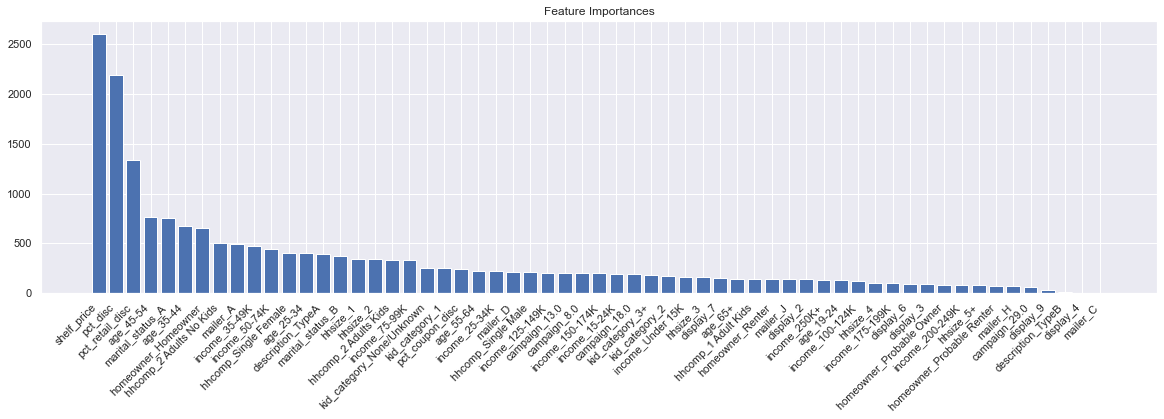

In [20]:
importances_unbalanced = lgbm_unbalanced.feature_importances_

indices = np.argsort(importances_unbalanced)[::-1]

# rearrange feature names so they match the sorted feature names
# I have my original names list of feature names, which corresponds to the features in the tree.
f_names = [X.columns [i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances_unbalanced[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right');

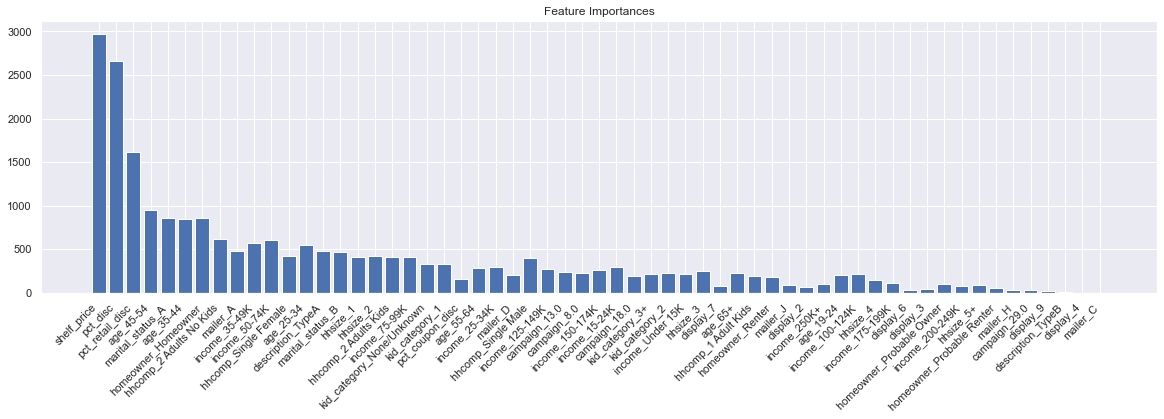

In [21]:
importances_unbalanced_3 = lgbm_unbalanced_3.feature_importances_

indices = np.argsort(importances_unbalanced)[::-1]

# rearrange feature names so they match the sorted feature names
# I have my original names list of feature names, which corresponds to the features in the tree.
f_names = [X.columns [i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances_unbalanced_3[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right');